In [1]:
!pip install opendatasets

In [44]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
# from torchvision.datasets import Imageforlder
import torchvision.datasets as datasets
from torch.utils.data import  random_split, DataLoader
import random
from skimage import io
import matplotlib.pyplot as plt
# para opendataset
import opendatasets as od
from fastai.vision.all import *
import numpy as np
import os


# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # Necesario para graficar superficies 3D

import pandas as pd

# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline


import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Descargamos el dataset
dataset_link = "https://www.kaggle.com/datasets/fedesoriano/wind-speed-prediction-dataset"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: carlososmar
Your Kaggle Key: ··········


100%|██████████| 71.6k/71.6k [00:00<00:00, 22.9MB/s]

In [45]:
df = pd.read_csv('/content/wind-speed-prediction-dataset/wind_dataset.csv')



# Normalizar los datos (escalamiento entre 0 y 1)
scaler = MinMaxScaler()
df['WIND'] = scaler.fit_transform(df['WIND'].values.reshape(-1, 1))

# Se convierte el DataFrame en una serie temporal
time_series = df['WIND']

# Se dividen los datos en conjuntos de entrenamiento, evaluación y prueba
train_size = int(len(time_series) * 0.7)
eval_size = int(len(time_series) * 0.1)

train_data = time_series[:train_size]
eval_data = time_series[train_size:train_size + eval_size]
test_data = time_series[train_size + eval_size:]

# Se crea la secuencia de datos
def create_sequences(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequence = data[i:i + window_size + 1]
        sequences.append(sequence)
    return np.array(sequences)


''' Para el primer DeepRNN'''

window_size = 50
X_train = create_sequences(train_data, window_size)
X_eval = create_sequences(eval_data, window_size)
X_test = create_sequences(test_data, window_size)


y_train = X_train[:, -10:].astype(np.float32)
y_eval = X_eval[:, -10:].astype(np.float32)
y_test = X_test[:, -10:].astype(np.float32)


# Se redefine las dimensiones de X_train, X_eval y X_test
X_train = X_train[:, :-1].astype(np.float32)
X_eval = X_eval[:, :-1].astype(np.float32)
X_test = X_test[:, :-1].astype(np.float32)

X_train= X_train[..., np.newaxis].astype(np.float32)
X_eval= X_eval[..., np.newaxis].astype(np.float32)
X_test= X_test[..., np.newaxis].astype(np.float32)



'''Segundo Deep RNN'''

# window_size = 50
# X_train = create_sequences(train_data, window_size)
# X_eval = create_sequences(eval_data, window_size)
# X_test = create_sequences(test_data, window_size)



# y_train = X_train[:, -50:].astype(np.float32)
# y_eval = X_eval[:, -50:].astype(np.float32)
# y_test = X_test[:, -50:].astype(np.float32)

# y_train = np.repeat(y_train[:, :, np.newaxis], 10, axis=2)
# y_eval = np.repeat(y_eval[:, :, np.newaxis], 10, axis=2)
# y_test = np.repeat(y_test[:, :, np.newaxis], 10, axis=2)

# Se redefine las dimensiones de X_train, X_eval y X_test
# X_train = X_train[:, :-1].astype(np.float32)
# X_eval = X_eval[:, :-1].astype(np.float32)
# X_test = X_test[:, :-1].astype(np.float32)

# X_train= X_train[..., np.newaxis].astype(np.float32)
# X_eval= X_eval[..., np.newaxis].astype(np.float32)
# X_test= X_test[..., np.newaxis].astype(np.float32)




# Imprme las dimensiones de los conjuntos de datos
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_eval:", X_eval.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_train:", y_eval.shape)
print("Dimensiones de y_train:", y_test.shape)


Dimensiones de X_train: (4551, 50, 1)
Dimensiones de X_eval: (607, 50, 1)
Dimensiones de X_test: (1266, 50, 1)
Dimensiones de y_train: (4551, 10)
Dimensiones de y_train: (607, 10)
Dimensiones de y_train: (1266, 10)


In [46]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix])

dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_eval, y_eval),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

In [47]:
''' para Primer DeepRNN'''
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=10):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()
    bar = tqdm(range(1, epochs+1))
    for epoch in bar:
        model.train()
        train_loss = []
        for batch in dataloader['train']:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        model.eval()
        eval_loss = []
        with torch.no_grad():
            for batch in dataloader['eval']:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
        bar.set_description(f"loss {np.mean(train_loss):.5f} val_loss {np.mean(eval_loss):.5f}")

def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [48]:
''' FIT PARA SEGUNDO DeepRNN'''
# from tqdm import tqdm
# device = "cuda" if torch.cuda.is_available() else "cpu"
# def fit(model, dataloader, epochs=10):
#     model.to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     criterion = torch.nn.MSELoss()
#     bar = tqdm(range(1, epochs+1))
#     for epoch in bar:
#         model.train()
#         train_loss = []
#         train_loss2 = []
#         for batch in dataloader['train']:
#             X, y = batch
#             X, y = X.to(device), y.to(device)
#             optimizer.zero_grad()
#             y_hat = model(X)
#             loss = criterion(y_hat, y)
#             loss.backward()
#             optimizer.step()
#             train_loss.append(loss.item())
#             train_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
#         model.eval()
#         eval_loss = []
#         eval_loss2 = []
#         with torch.no_grad():
#             for batch in dataloader['eval']:
#                 X, y = batch
#                 X, y = X.to(device), y.to(device)
#                 y_hat = model(X)
#                 loss = criterion(y_hat, y)
#                 eval_loss.append(loss.item())
#                 eval_loss2.append((y[:,-1] - y_hat[:,-1]).pow(2).mean().item())
#         bar.set_description(f"loss {np.mean(train_loss):.5f} loss_last_step {np.mean(train_loss2):.5f} val_loss {np.mean(eval_loss):.5f} val_loss_last_step {np.mean(eval_loss2):.5f}")

# def predict(model, dataloader):
#     model.eval()
#     with torch.no_grad():
#         preds = torch.tensor([]).to(device)
#         for batch in dataloader:
#             X = batch
#             X = X.to(device)
#             pred = model(X)
#             preds = torch.cat([preds, pred])
#         return preds


' FIT PARA SEGUNDO DeepRNN'

In [49]:
''' priemer DeepRNN'''

class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=10):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, n_out)

    self.rnn = self.rnn.to(torch.float32)  # Convert the RNN layer to float32
    self.fc = self.fc.to(torch.float32)

  def forward(self, x):
    x, h = self.rnn(x)
    x = self.fc(x[:,-1])
    return x

'''segundo DeepRNN'''
# class DeepRNN(torch.nn.Module):
#   def __init__(self, n_out=10):
#     super().__init__()
#     self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
#     self.fc = torch.nn.Linear(20, n_out)

#   def forward(self, x):
#     x, h = self.rnn(x)
#     # print(x.shape)
#     # [ Batch, time steps, features ] --> [ Batch x time steps, features ]
#     # print(x.size(-1))

#     x_reshaped = x.contiguous().view(-1, x.size(-1))
#     # print(x_reshaped.shape)
#     # print("##"*30)
#     y = self.fc(x_reshaped)
#     # [ Batch x time steps, features ] --> [ Batch, time steps, features ]
#     y = y.contiguous().view(x.size(0), -1, y.size(-1))
#     return y

rnn = DeepRNN()

In [50]:
fit(rnn, dataloader)

loss 0.00478 val_loss 0.00341: 100%|██████████| 10/10 [00:01<00:00,  5.41it/s]


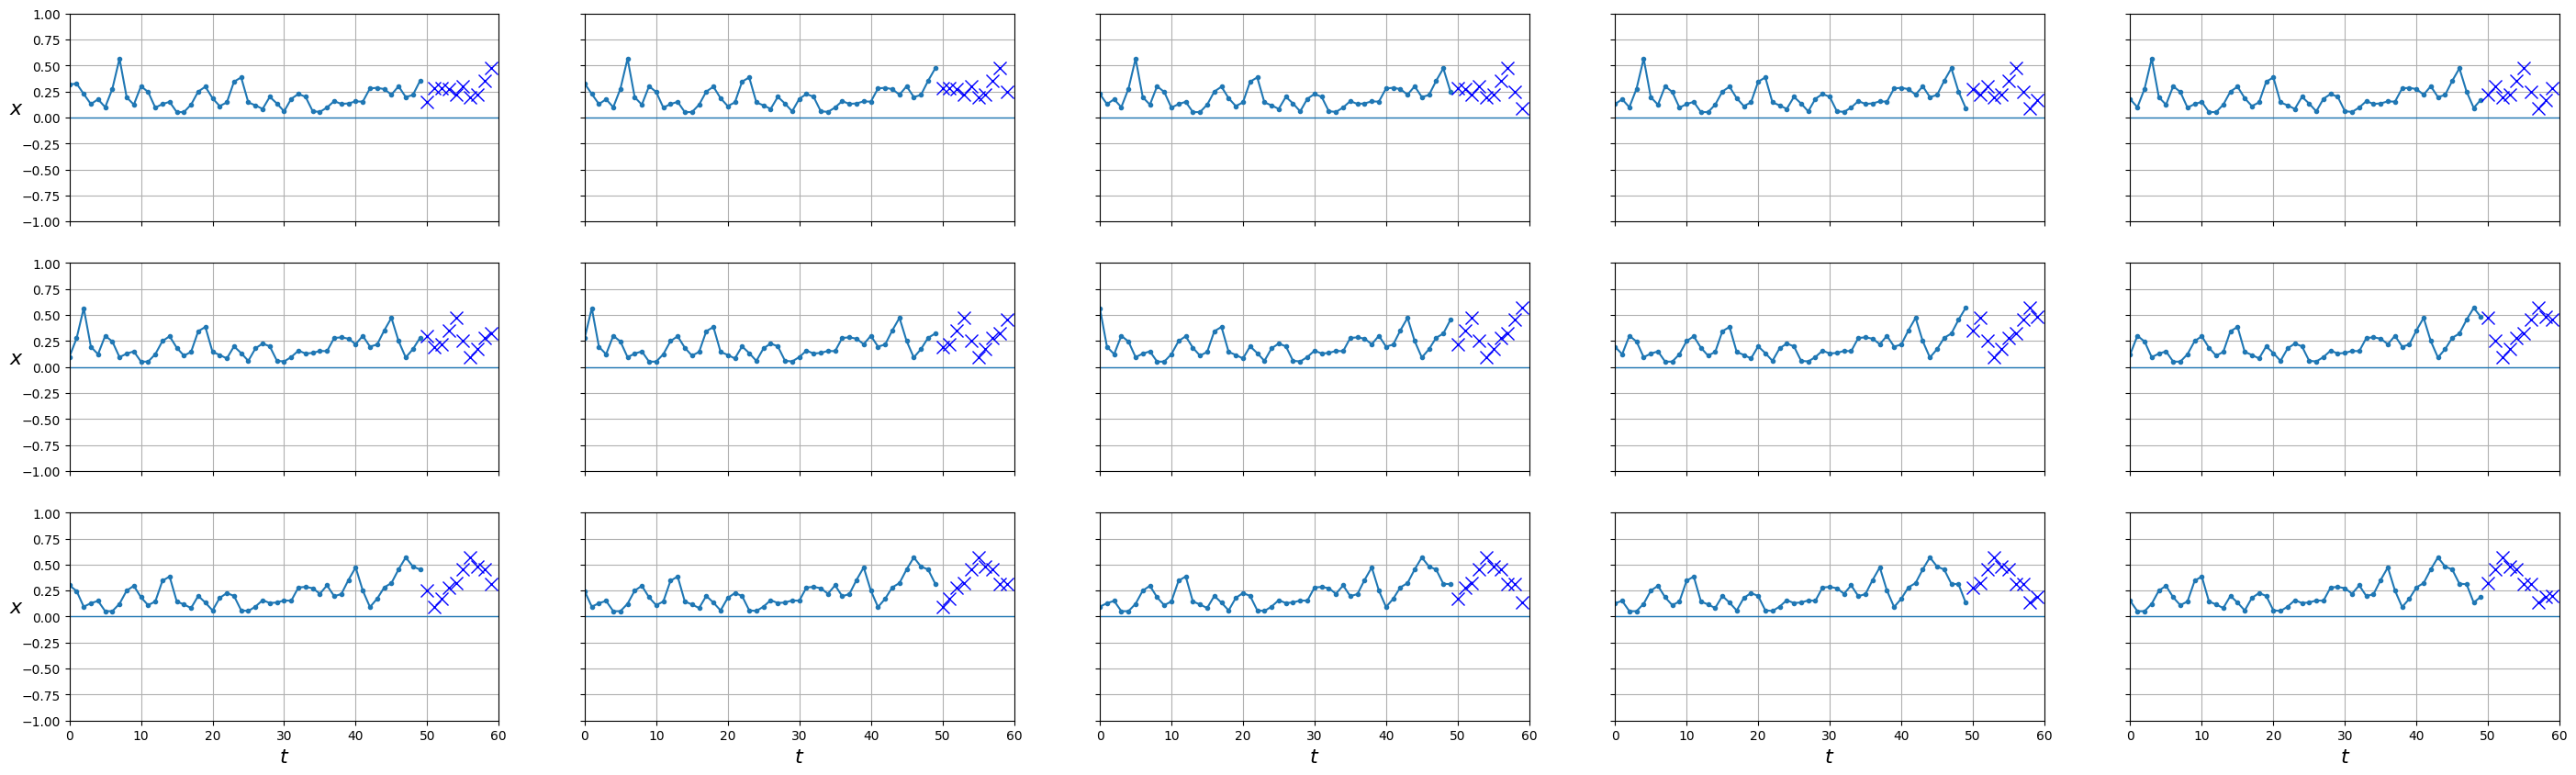

In [51]:
import matplotlib.pyplot as plt

def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(35, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()

plot_series(X_test, y_test)

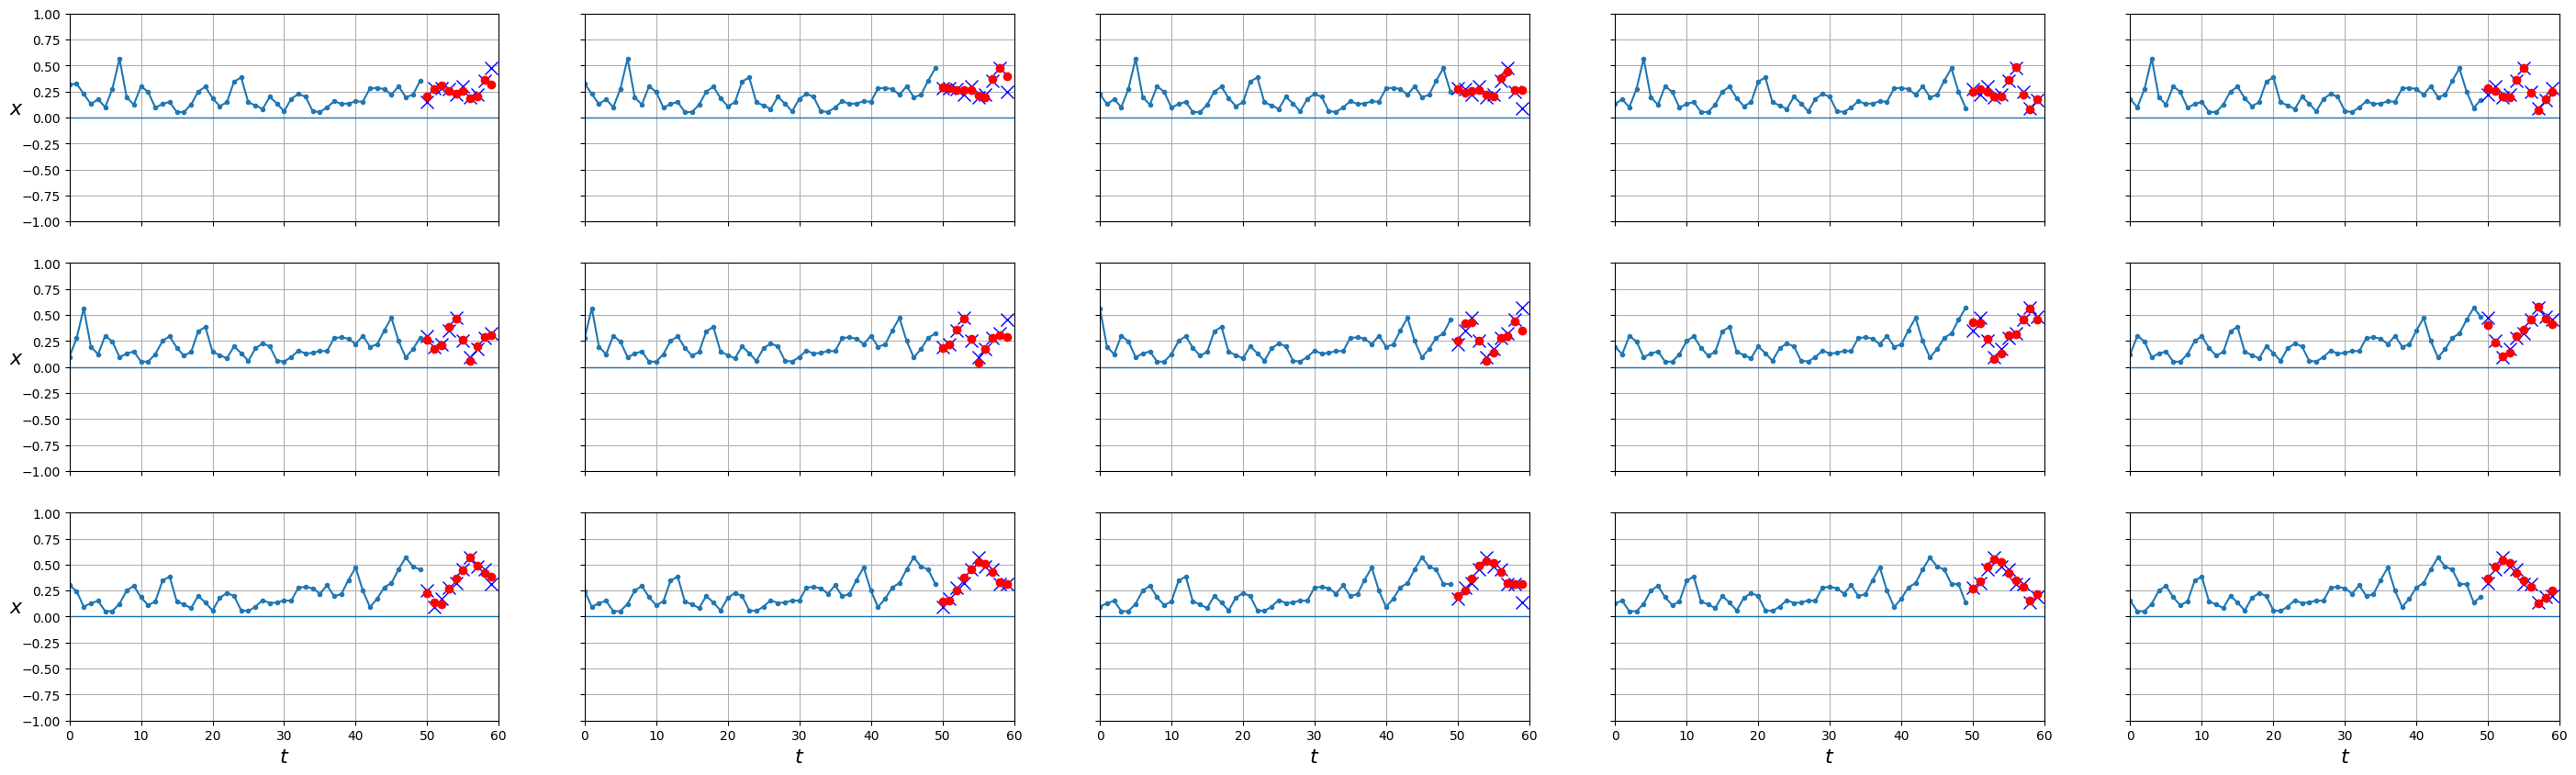

0.0038930043

In [52]:
from sklearn.metrics import mean_squared_error

y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())
mean_squared_error(y_test, y_pred.cpu())

# y_pred = predict(rnn, dataloader['test'])
# plot_series(X_test, y_test[:,:,-1], y_pred[:,:,-1].cpu().numpy())
# mean_squared_error(y_test[:,:,-1], y_pred[:,:,-1].cpu())